<a href="https://colab.research.google.com/github/ssssuyeon/code-practice/blob/main/adversarial_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
from PIL import Image
import cv2
import imageio
import torchvision.transforms as transforms
import shutil
mpl.rcParams['figure.figsize'] = (8, 10)
mpl.rcParams['axes.grid'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet 클래스 레이블
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [ ]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [ ]:
image_file_path = '/content/drive/MyDrive/train/'
image_name = os.listdir(image_file_path)
out_dir = '/content/drive/MyDrive/advtrain/'

In [ ]:
image_path = image_file_path + image_name[0]
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image1 = image.shape[0]
image2 = image.shape[1]
image = preprocess(image)
image_probs = pretrained_model.predict(image)

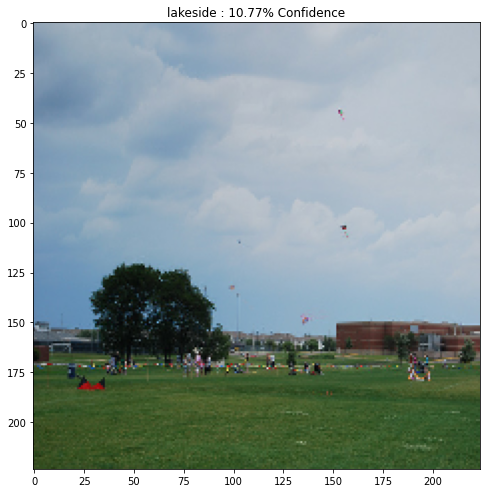

In [ ]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
#epsilons = [0, 0.01, 0.1, 0.15]
for i in range(len(image_name)):
  image_path = image_file_path + image_name[i]
  image_raw = tf.io.read_file(image_path)
  image = tf.image.decode_image(image_raw)
  image1 = image.shape[0]
  image2 = image.shape[1]
  image = preprocess(image)
  try:
    image_probs = pretrained_model.predict(image)
  except ValueError:
    source = image_path
    destination = out_dir + image_name[i]
    shutil.copyfile(source,destination)
    continue 
  labrador_retriever_index = np.argmax(image_probs)
  label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))
  perturbations = create_adversarial_pattern(image, label)

  epsilons = 0.007


  adv_x = image + epsilons*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  pil_img = tf.keras.preprocessing.image.array_to_img(adv_x[0])
  pil_img = pil_img.resize((image2, image1))
  pil_img.save(out_dir + image_name[i])

In [ ]:
pil_img = tf.keras.preprocessing.image.array_to_img(adv_x[0])
pil_img = pil_img.resize((image2, image1))
pil_img.save('/content/drive/MyDrive/advtrain/sample.jpg')